/tmp/ipykernel_2434366/3264175324.py:74: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_44005= pd.read_csv(pp_root_buo+'44005.txt', sep=r'[ \s]+')  # Or the appropriate delimiter


123 -69.25
173 43.25


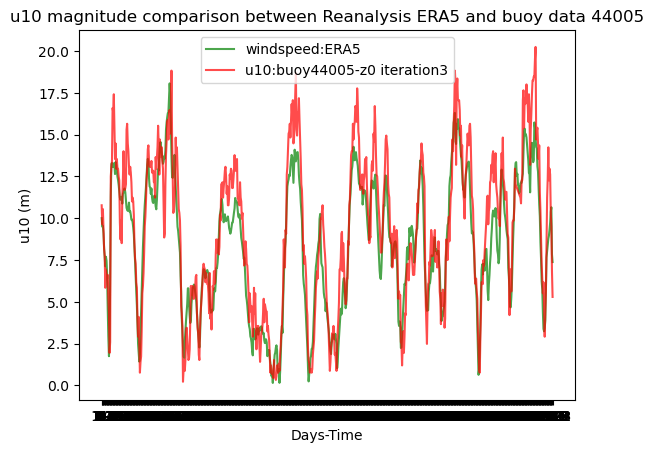

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import xarray as xr
import numpy as np
import logging
from netCDF4 import Dataset
import netCDF4
import pandas as pd
import math

def cal_z0(uref):
    import math
    
    # Coefficients
    p13 = -1.296521881682694e-02
    p12 =  2.855780863283819e-01
    p11 = -1.597898515251717e+00
    p10 = -8.396975715683501e+00
    
    p25 =  3.790846746036765e-10
    p24 =  3.281964357650687e-09
    p23 =  1.962282433562894e-07
    p22 = -1.240239171056262e-06
    p21 =  1.739759082358234e-07
    p20 =  2.147264020369413e-05
    
    p35 =  1.840430200185075e-07
    p34 = -2.793849676757154e-05
    p33 =  1.735308193700643e-03
    p32 = -6.139315534216305e-02
    p31 =  1.255457892775006e+00
    p30 = -1.663993561652530e+01
    
    p40 =  4.579369142033410e-04

    if 0.0 <= uref <= 6.5:
        z0 = math.exp(p10 + p11 * uref + p12 * uref**2 + p13 * uref**3)
    elif 6.5 < uref <= 15.7:
        z0 = (p25 * uref**5 + p24 * uref**4 + p23 * uref**3 +
              p22 * uref**2 + p21 * uref + p20)
    elif 15.7 < uref <= 53.0:
        z0 = math.exp(p35 * uref**5 + p34 * uref**4 + p33 * uref**3 +
                      p32 * uref**2 + p31 * uref + p30)
    elif uref > 53.0:
        z0 = p40
    else:
        raise ValueError(f"Wrong input uref value: {uref}")
        z0=0
    return z0

def u10_cal(uref,z_bouy,n):
    import math
    k=0.4
 #   cd=1.2*10**(-3)
    z0=9.7*10**(-5)
#    u10_ini=uref*math.sqrt(k**2/cd)/(math.log(z_bouy/z0))
    u10_ini=uref*math.log(10/z0)/math.log(z_bouy/z0)
    for i in range(n):
        z0=cal_z0(u10_ini)
      #  cd=(k/math.log(z_bouy/z0))**2
     #   print(f"without correcting u10_ini {u10_ini}")
 #       u10_ini=u10_ini*math.sqrt(k**2/cd)/(math.log(z_bouy/z0))
        u10_ini=uref*math.log(10/z0)/math.log(z_bouy/z0)
   #     print(f"iteration {i} z0 is {z0}, u10 {u10_ini}" )
    return u10_ini
        
    

    
x_bouy_44005=-69.127
y_bouy_44005=43.201
z_bouy_44005=3.8
pp_root_buo="/gpfs/f5/gfdl_o/scratch/Qian.Xiao/FMS_Wave_Coupling_ZC/examples/NWA12.COBALT_wave/WW3/PostProc/"
data_44005= pd.read_csv(pp_root_buo+'44005.txt', sep=r'[ \s]+')  # Or the appropriate delimiter
data_44005= pd.DataFrame(data_44005)

data_44005 = data_44005[data_44005['WVHT'] != 99.0]
days_44005 = data_44005.DD.astype(str).to_numpy()
hours_44005= data_44005.hh.astype(str).to_numpy()
t_44005 = [x +'-'+y for x, y in zip(days_44005, hours_44005)]

u10_vec_function = np.vectorize(u10_cal)
u10_10bouy=u10_vec_function(np.array(data_44005.WSPD),z_bouy_44005,3)

#u10_10bouy=np.array(data_44005.WSPD)*math.sqrt(k**2/cd)/(np.log(z_bouy_44005/z0))

# z0=0.0002 #0.007/0.015
# u10_10bouy=np.array(data_44005.WSPD)*np.log(10/z0)/np.log(z_bouy_44005/z0)

pp_root_wave="/gpfs/f5/gfdl_med/world-shared/northwest_atlantic/era5/"
u10_data=xr.open_dataset(pp_root_wave+"ERA5_u10_1993_padded.nc")
v10_data=xr.open_dataset(pp_root_wave+"ERA5_v10_1993_padded.nc")
lat_y=np.array(u10_data.latitude)
lon_x=np.array(u10_data.longitude)-360

t=np.array(u10_data.time)
u10_u=u10_data.u10
v10_v=v10_data.v10
years=pd.to_datetime(t).year
months=pd.to_datetime(t).month
days=pd.to_datetime(t).day
hours=pd.to_datetime(t).hour
days=days.astype(str).to_numpy()
hours=hours.astype(str).to_numpy()
t_era5 = [x + '-'+y for x, y in zip(days, hours)]

x_index=np.abs(lon_x-x_bouy_44005).argmin()
y_index=np.abs(lat_y-y_bouy_44005).argmin()

print(x_index,lon_x[x_index])
print(y_index,lat_y[y_index])
u10_era5=u10_u[:744,y_index,x_index]
v10_era5=v10_v[:744,y_index,x_index]
windspeed_44005 = np.sqrt(u10_era5**2+v10_era5**2)

plt.plot(t_era5[:744],windspeed_44005,'g', alpha=0.7, label='windspeed:ERA5')
plt.plot(t_44005,u10_10bouy,'r', alpha=0.7, label='u10:buoy44005-z0 iteration3')
plt.legend(loc='best'); plt.xlabel('Days-Time'); plt.ylabel('u10 (m)'); plt.title('u10 magnitude comparison between Reanalysis ERA5 and buoy data 44005');




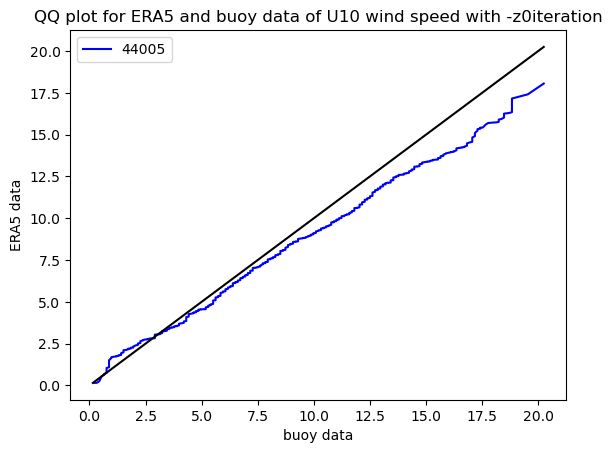

In [5]:
# def QQplot(test1,test2,test1label,test2label,title_qq,legend,color):
import pylab
import numpy as np
test1label='buoy data'
test2label='ERA5 data'
test1=u10_10bouy
test2=windspeed_44005
title_qq='QQ plot for ERA5 and buoy data of U10 wind speed with -z0iteration'
legend='44005'
color='b'

test1=np.array(test1)
test2=np.array(test2)
reverse=False
if len(test1)<len(test2):
    tem=test2
    test2=test1
    test1=tem
    reverse=True
    
#Calculate quantiles
test1.sort()
quantile_levels1 = np.arange(len(test1),dtype=float)/len(test1)

test2.sort()
quantile_levels2 = np.arange(len(test2),dtype=float)/len(test2)

#Use the smaller set of quantile levels to create the plot
quantile_levels = quantile_levels2

#We already have the set of quantiles for the smaller data set
quantiles2 = test2

#We find the set of quantiles for the larger data set using linear interpolation
quantiles1 = np.interp(quantile_levels,quantile_levels1,test1)

#Plot the quantiles to create the qq plot
if reverse==False:
    pylab.plot(quantiles1,quantiles2,color=color,label=legend)
    pylab.xlabel(test1label)
    pylab.ylabel(test2label)
else:
    pylab.plot(quantiles2,quantiles1,color=color,label=legend)
    pylab.xlabel(test1label)
    pylab.ylabel(test2label)


#Add a reference line
maxval = max(test1[-1],test2[-1])
minval = min(test1[0],test2[0])
pylab.plot([minval,maxval],[minval,maxval],'k-')
pylab.title(title_qq)
pylab.legend()

/tmp/ipykernel_2434366/4045225645.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_41002= pd.read_csv(pp_root_buo+'41002.txt', sep=r'[ \s]+')  # Or the appropriate delimiter


100 -75.0
127 31.75


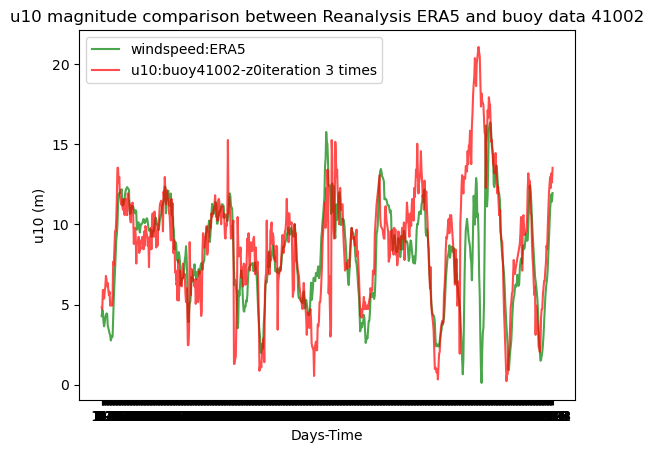

In [3]:
data_41002= pd.read_csv(pp_root_buo+'41002.txt', sep=r'[ \s]+')  # Or the appropriate delimiter
data_41002= pd.DataFrame(data_41002)
x_bouy_41002=-74.936
y_bouy_41002=31.759
z_bouy_41002=4.1

data_41002 = data_41002[data_41002['WVHT'] != 99.0]
days_41002 = data_41002.DD.astype(str).to_numpy()
hours_41002= data_41002.hh.astype(str).to_numpy()
t_41002 = [x +'-'+y for x, y in zip(days_41002, hours_41002)]

u10_vec_function = np.vectorize(u10_cal)
u10_10bouy=u10_vec_function(np.array(data_41002.WSPD),z_bouy_41002,3)

# k=0.4
# cd=1.2*10**(-3)
# cd=cd*2
# z0=9.7*10**(-5)
# z0=z0*2
# u10_10bouy=np.array(data_41002.WSPD)*math.sqrt(k**2/cd)/(np.log(z_bouy_41002/z0))

# z0=0.0002 #0.007/0.015
# u10_10bouy=np.array(data_41002.WSPD)*np.log(10/z0)/np.log(z_bouy_41002/z0)


x_index=np.abs(lon_x-x_bouy_41002).argmin()
y_index=np.abs(lat_y-y_bouy_41002).argmin()

print(x_index,lon_x[x_index])
print(y_index,lat_y[y_index])
u10_era5=u10_u[:744,y_index,x_index]
v10_era5=v10_v[:744,y_index,x_index]
windspeed_41002 = np.sqrt(u10_era5**2+v10_era5**2)


plt.plot(t_era5[:744],windspeed_41002,'g', alpha=0.7, label='windspeed:ERA5')
plt.plot(t_41002,u10_10bouy,'r', alpha=0.7, label='u10:buoy41002-z0iteration 3 times')
plt.legend(loc='best'); plt.xlabel('Days-Time'); plt.ylabel('u10 (m)'); plt.title('u10 magnitude comparison between Reanalysis ERA5 and buoy data 41002');




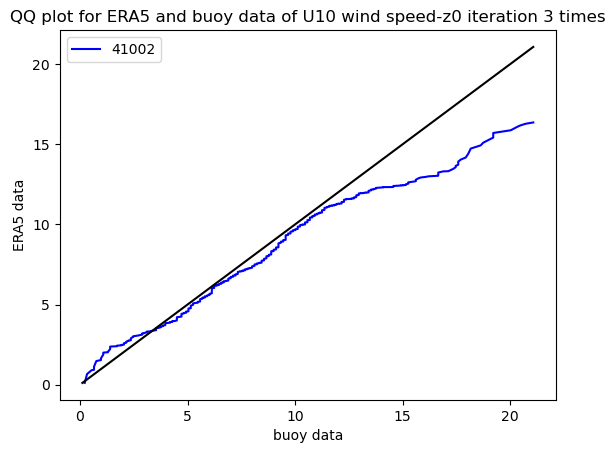

In [5]:
import pylab
import numpy as np
test1label='buoy data'
test2label='ERA5 data'
test1=u10_10bouy
test2=windspeed_41002
title_qq='QQ plot for ERA5 and buoy data of U10 wind speed-z0 iteration 3 times'
legend='41002'
color='b'

test1=np.array(test1)
test2=np.array(test2)
reverse=False
if len(test1)<len(test2):
    tem=test2
    test2=test1
    test1=tem
    reverse=True
    
#Calculate quantiles
test1.sort()
quantile_levels1 = np.arange(len(test1),dtype=float)/len(test1)

test2.sort()
quantile_levels2 = np.arange(len(test2),dtype=float)/len(test2)

#Use the smaller set of quantile levels to create the plot
quantile_levels = quantile_levels2

#We already have the set of quantiles for the smaller data set
quantiles2 = test2

#We find the set of quantiles for the larger data set using linear interpolation
quantiles1 = np.interp(quantile_levels,quantile_levels1,test1)

#Plot the quantiles to create the qq plot
if reverse==False:
    pylab.plot(quantiles1,quantiles2,color=color,label=legend)
    pylab.xlabel(test1label)
    pylab.ylabel(test2label)
else:
    pylab.plot(quantiles2,quantiles1,color=color,label=legend)
    pylab.xlabel(test1label)
    pylab.ylabel(test2label)


#Add a reference line
maxval = max(test1[-1],test2[-1])
minval = min(test1[0],test2[0])
pylab.plot([minval,maxval],[minval,maxval],'k-')
pylab.title(title_qq)
pylab.legend()

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  ,
       11.25, 11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25,
       13.5 , 13.75, 14.  , 14.25, 14.5 , 14.75, 15.  , 15.25, 15.5 ,
       15.75, 16.  , 16.25, 16.5 , 16.75, 17.  , 17.25, 17.5 , 17.75,
       18.  , 18.25, 18.5 , 18.75, 19.  , 19.25, 19.5 , 19.75, 20.  ,
       20.25, 20.5 , 20.75, 21.  , 21.25, 21.5 , 21.75, 22.  , 22.25,
       22.5 , 22.75, 23.  , 23.25, 23.5 , 23.75, 24.  , 24.25, 24.5 ,
       24.75, 25.  , 25.25, 25.5 , 25.75, 26.  , 26.25, 26.5 , 26.75,
       27.  , 27.25, 27.5 , 27.75, 28.  , 28.25, 28.5 , 28.75, 29.  ,
       29.25, 29.5 , 29.75, 30.  , 30.25, 30.5 , 30.75, 31.  , 31.25,
       31.5 , 31.75,

In [3]:
u10_era5

<xarray.DataArray 'u10' (time: 744)>
array([  9.492383,   9.404187,   9.510022, ..., -10.34718 ,  -7.63517 ,
        -7.324282])
Coordinates:
    latitude   float32 43.25
    longitude  float32 290.8
  * time       (time) datetime64[ns] 1993-01-01 ... 1993-01-31T23:00:00
Attributes:
    units:      m s**-1
    long_name:  10 metre U wind component

In [19]:
u10=10.699960839551089
z0=cal_z0(u10)
k=0.4
cd=(k/math.log(z_bouy_44005/z0))**2
u10_ini=u10*math.sqrt(k**2/cd)/(math.log(z_bouy_44005/z0))
u10_ini

10.699960839551089